# 1. Get Data

In [1]:
import csv
import json
import sys
import datetime
import matplotlib.pyplot as plt
from pytz import timezone
import hashlib
import pandas as pd

In [45]:
tweets_data = pd.read_csv('tweets/tweets_2.csv', delimiter=';').sort_values(by='created_at').reset_index(drop=True)
tweets_data.head()

,id,created_at,full_text
0,14136,2020-04-09 00:00:01+00:00,S&amp;P 500 | $SPX | $SPX500 $USD\n\nS&amp;P T...
1,14134,2020-04-09 00:00:15+00:00,Why #realestate beats #stocks during a #recess...
2,14133,2020-04-09 00:00:15+00:00,RT @DisneyTVANews: It's been confirmed that @D...
3,14130,2020-04-09 00:00:26+00:00,"Daily, Weekly, Monthly &amp; Annual Pivots &am..."
4,14132,2020-04-09 00:00:26+00:00,This private #stocks #swingtrading https://t.c...


In [15]:
start_date = tweets_data['created_at'].min()
end_date = tweets_data['created_at'].max()

In [16]:
print(start_date)
print(end_date)

2020-04-09 00:00:01+00:00
2020-07-16 23:59:13+00:00


# 2. Preprocess

## I. removal of stop-words and punctuation<br>

refer: http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf

In [23]:
# 如果你想往前移再往前拿
from nltk.corpus import stopwords
import re

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
EngStopWords = set(stopwords.words('english'))

In [26]:
def preprocess(text): 
    text = re.sub(r'[^\w\s]',' ',text)
    
    tokens = []
    for word in text.split():
        if word in EngStopWords:
            pass #如果詞彙是個英文的停用詞的話，就略過不處理。
        else:
            tokens.append(word)
    return tokens


In [28]:
tryyy = tweets_data['full_text'][0]
# preprocess(tryyy)
tryyy

'S&amp;P 500 | $SPX | $SPX500 $USD\n\nS&amp;P TARGETS 1550 - 1835\n\nLong or short it with BTC on Trade8: https://t.co/7IRjHNUtDw https://t.co/WmLbmm8uoR'

In [30]:
#start replaceTwoOrMore
def replaceTwoOrMore(s):
    #look for 2 or more repetitions of character
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL) 
    return pattern.sub(r"\1\1", s)

#start process_tweet
def processTweet(tweet):
    # process the tweets
    
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)    
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    return tweet

#start getStopWordList
def getStopWordList(stopWordListFileName):
    #read the stopwords
    stopWords = []
    stopWords.append('AT_USER')
    stopWords.append('URL')

    fp = open(stopWordListFileName, 'r')
    line = fp.readline()
    while line:
        word = line.strip()
        stopWords.append(word)
        line = fp.readline()
    fp.close()
    return stopWords

#start getfeatureVector
def getFeatureVector(tweet, stopWords):
    featureVector = []  
    words = tweet.split()
    for w in words:
        #replace two or more with two occurrences 
        w = replaceTwoOrMore(w) 
        #strip punctuation
        w = w.strip('\'"?,.')
        #check if it consists of only words
        val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*[a-zA-Z]+[a-zA-Z0-9]*$", w)
        #ignore if it is a stopWord
        if(w in stopWords or val is None):
            continue
        else:
            featureVector.append(w.lower())
    return featureVector   

#start extract_features
def extract_features(tweet):
    tweet_words = set(tweet)
    features = {}
    for word in featureList:
        features['contains(%s)' % word] = (word in tweet_words)
    return 


In [31]:
count = 0;
featureList = []
tweets = []

In [32]:
tryyy

'S&amp;P 500 | $SPX | $SPX500 $USD\n\nS&amp;P TARGETS 1550 - 1835\n\nLong or short it with BTC on Trade8: https://t.co/7IRjHNUtDw https://t.co/WmLbmm8uoR'

In [36]:
tweet = str(tryyy)
processedTweet = processTweet(tweet)
featureVector = getFeatureVector(processedTweet, EngStopWords)
featureList.extend(featureVector)
tweets.append((featureVector))

In [37]:
print(featureList)
print(tweets)

['targets', 'long', 'short', 'btc', 'url', 'url', 'targets', 'long', 'short', 'btc', 'url', 'url']
[['targets', 'long', 'short', 'btc', 'url', 'url']]


In [50]:
distil_df = tweets_data.drop(columns=['id'])
# 轉換created_at
distil_df ['created_at'] = distil_df ['created_at'].astype('str')
distil_df['date'] = pd.to_datetime( distil_df['created_at'], format="%Y-%m-%d %H:%M:%S+00:00")
distil_df = distil_df.sort_values(by=['date'], ignore_index = True)

# 轉換tweets
distil_df ['tweets'] = distil_df ['full_text'].astype('str')

del distil_df ['created_at'] 
del distil_df ['full_text'] 
distil_df.head()

,date,tweets
0,2020-04-09 00:00:01,S&amp;P 500 | $SPX | $SPX500 $USD\n\nS&amp;P T...
1,2020-04-09 00:00:15,Why #realestate beats #stocks during a #recess...
2,2020-04-09 00:00:15,RT @DisneyTVANews: It's been confirmed that @D...
3,2020-04-09 00:00:26,"Daily, Weekly, Monthly &amp; Annual Pivots &am..."
4,2020-04-09 00:00:26,This private #stocks #swingtrading https://t.c...


In [51]:
distil_df.describe()

C:\Users\USER\AppData\Local\Temp\ipykernel_14960\3043079737.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  distil_df.describe()


,date,tweets
count,923673,923673
unique,829053,677585
top,2020-06-29 02:00:04,"RT @ChrisDungeon: ""Innovation has nothing to d..."
freq,22,1677
first,2020-04-09 00:00:01,NaN
last,2020-07-16 23:59:13,NaN


In [52]:
def preprocess(text):
    tweet = str(text)
    processedTweet = processTweet(tweet)
    featureVector = getFeatureVector(processedTweet, EngStopWords)
    return featureVector 

In [53]:
distil_df['tweets']

0         S&amp;P 500 | $SPX | $SPX500 $USD\n\nS&amp;P T...
1         Why #realestate beats #stocks during a #recess...
2         RT @DisneyTVANews: It's been confirmed that @D...
3         Daily, Weekly, Monthly &amp; Annual Pivots &am...
4         This private #stocks #swingtrading https://t.c...
                                ...                        
923668    Quality company proving during hard times #JNJ...
923669    RT @ABiggzHD: Small Account: NA\nBig Account: ...
923670    If $AMZN dropped below $2,000 I would LOVE to ...
923671                     $MS $BAC https://t.co/o7Vm9UFCC9
923672    Analyst Has Outperform Rating on Company with ...
Name: tweets, Length: 923673, dtype: object

In [54]:
distil_df['tweets_processed'] = distil_df.apply(lambda x: preprocess(x['tweets']),axis=1)
del distil_df['tweets']
distil_df

,date,tweets_processed
0,2020-04-09 00:00:01,"[targets, long, short, btc, url, url]"
1,2020-04-09 00:00:15,"[realestate, beats, stocks, recession, housing..."
2,2020-04-09 00:00:15,"[rt, confirmed, arrive, japan, later, year, qu..."
3,2020-04-09 00:00:26,"[daily, weekly, monthly, annual, pivots, camar..."
4,2020-04-09 00:00:26,"[private, stocks, swingtrading, url, help, fin..."
...,...,...
923668,2020-07-16 23:58:57,"[quality, company, proving, hard, times, jnj, ..."
923669,2020-07-16 23:58:59,"[rt, small, na, big, alerted, trades, live, jo..."
923670,2020-07-16 23:59:03,"[dropped, would, love, add, position, notafina..."
923671,2020-07-16 23:59:12,[url]


### GPOMS data
為啥要不同的pre-processing?

-> 這part我沒跑

In [55]:
def processTweet_G(tweet):

    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)    
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    return tweet

def preprocess_GPOMS(text):
    tweet = str(text)
    processedTweet = processTweet_G(tweet)
#     featureVector = getFeatureVector(processedTweet, EngStopWords)
    return processedTweet

In [57]:
distil_df

,date,tweets_processed
0,2020-04-09 00:00:01,"[targets, long, short, btc, url, url]"
1,2020-04-09 00:00:15,"[realestate, beats, stocks, recession, housing..."
2,2020-04-09 00:00:15,"[rt, confirmed, arrive, japan, later, year, qu..."
3,2020-04-09 00:00:26,"[daily, weekly, monthly, annual, pivots, camar..."
4,2020-04-09 00:00:26,"[private, stocks, swingtrading, url, help, fin..."
...,...,...
923668,2020-07-16 23:58:57,"[quality, company, proving, hard, times, jnj, ..."
923669,2020-07-16 23:58:59,"[rt, small, na, big, alerted, trades, live, jo..."
923670,2020-07-16 23:59:03,"[dropped, would, love, add, position, notafina..."
923671,2020-07-16 23:59:12,[url]


In [64]:
GPOMS_df = pd.DataFrame(prune_tweets_data, columns=['created_at','tweets'])
GPOMS_df['tweets_processed'] = GPOMS_df.apply(lambda x: preprocess_GPOMS(x['tweets']),axis=1)
del GPOMS_df['tweets']
GPOMS_df

,created_at,tweets_processed
0,2022-05-01 12:00:47+00:00,b'find out how our customized operator trainin...
1,2022-05-01 12:08:13+00:00,"b""while the day for when we'll have a powerful..."
2,2022-05-01 13:53:45+00:00,b'it was never about what she got from basketb...
3,2022-05-01 15:00:01+00:00,"b'when the pandemic hit, principal akbar cook\..."
4,2022-05-01 15:00:25+00:00,b'is it time to ditch the resume?\n\nas an emp...
...,...,...
3083,2022-06-30 23:00:31+00:00,"b'after getting their hands a little dirty, cr..."
3084,2022-06-30 23:08:11+00:00,"b"" have until july 7th. you're welcome \xf0\x9..."
3085,2022-06-30 23:26:35+00:00,"b""rt it's time to rise together! \xf0\x9f\x8f\..."
3086,2022-06-30 23:31:00+00:00,"b' hi danae, so sorry to hear this. looping in..."


In [65]:
GPOMS_df['tweet_size'] = GPOMS_df['tweets_processed'].map(len)
GPOMS_df

,created_at,tweets_processed,tweet_size
0,2022-05-01 12:00:47+00:00,b'find out how our customized operator trainin...,130
1,2022-05-01 12:08:13+00:00,"b""while the day for when we'll have a powerful...",124
2,2022-05-01 13:53:45+00:00,b'it was never about what she got from basketb...,130
3,2022-05-01 15:00:01+00:00,"b'when the pandemic hit, principal akbar cook\...",141
4,2022-05-01 15:00:25+00:00,b'is it time to ditch the resume?\n\nas an emp...,132
...,...,...,...
3083,2022-06-30 23:00:31+00:00,"b'after getting their hands a little dirty, cr...",130
3084,2022-06-30 23:08:11+00:00,"b"" have until july 7th. you're welcome \xf0\x9...",55
3085,2022-06-30 23:26:35+00:00,"b""rt it's time to rise together! \xf0\x9f\x8f\...",149
3086,2022-06-30 23:31:00+00:00,"b' hi danae, so sorry to hear this. looping in...",75


In [67]:
GPOMS_df.describe()

,tweet_size
count,3088.000000
mean,123.701425
std,32.318110
min,1.000000
25%,114.000000
50%,129.000000
75%,140.250000
max,345.000000


In [70]:
GPOMS_df.to_pickle("corpus_GPOMS.pkl")

## II. group all tweets that were submitted on the same date

In [59]:
distil_df['date_prune'] = distil_df.apply(lambda x: datetime.datetime.strftime(x['date'], "%Y-%m-%d"),axis=1)
del distil_df['date'] 
distil_df

,tweets_processed,date_prune
0,"[targets, long, short, btc, url, url]",2020-04-09
1,"[realestate, beats, stocks, recession, housing...",2020-04-09
2,"[rt, confirmed, arrive, japan, later, year, qu...",2020-04-09
3,"[daily, weekly, monthly, annual, pivots, camar...",2020-04-09
4,"[private, stocks, swingtrading, url, help, fin...",2020-04-09
...,...,...
923668,"[quality, company, proving, hard, times, jnj, ...",2020-07-16
923669,"[rt, small, na, big, alerted, trades, live, jo...",2020-07-16
923670,"[dropped, would, love, add, position, notafina...",2020-07-16
923671,[url],2020-07-16


In [60]:
sector = distil_df.groupby("date_prune")
sector.size()

date_prune
2020-04-09    13941
2020-04-10     6639
2020-04-11     5308
2020-04-12     6150
2020-04-13    12602
              ...  
2020-07-12     7450
2020-07-13    19066
2020-07-14    17296
2020-07-15    16682
2020-07-16    14127
Length: 77, dtype: int64

In [62]:
condense_df = distil_df.groupby("date_prune").agg({'tweets_processed':'sum'})
condense_df

,tweets_processed
date_prune,
2020-04-09,"[targets, long, short, btc, url, url, realesta..."
2020-04-10,"[short, sale, volume, short, url, shape, recov..."
2020-04-11,"[jeffreyepstein, ghislainemaxwell, markepstein..."
2020-04-12,"[rt, biggest, mistakes, apple, pc, maker, amaz..."
2020-04-13,"[short, sale, volume, short, url, profit, earn..."
...,...
2020-07-12,"[want, learn, yaonology, service, visit, new, ..."
2020-07-13,"[breaking, finances, valuation, url, url, url,..."
2020-07-14,"[apple, air, pods, wired, charging, url, apple..."


In [63]:
condense_df['tweet_size'] = condense_df['tweets_processed'].map(len)
condense_df

,tweets_processed,tweet_size
date_prune,,
2020-04-09,"[targets, long, short, btc, url, url, realesta...",153618
2020-04-10,"[short, sale, volume, short, url, shape, recov...",77124
2020-04-11,"[jeffreyepstein, ghislainemaxwell, markepstein...",60031
2020-04-12,"[rt, biggest, mistakes, apple, pc, maker, amaz...",66723
2020-04-13,"[short, sale, volume, short, url, profit, earn...",136188
...,...,...
2020-07-12,"[want, learn, yaonology, service, visit, new, ...",81464
2020-07-13,"[breaking, finances, valuation, url, url, url,...",205455
2020-07-14,"[apple, air, pods, wired, charging, url, apple...",190338


In [64]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [115]:
tmp = condense_df.reset_index()
tmp

,date_prune,tweets_processed,tweet_size
0,2020-04-09,"[targets, long, short, btc, url, url, realesta...",153618
1,2020-04-10,"[short, sale, volume, short, url, shape, recov...",77124
2,2020-04-11,"[jeffreyepstein, ghislainemaxwell, markepstein...",60031
3,2020-04-12,"[rt, biggest, mistakes, apple, pc, maker, amaz...",66723
4,2020-04-13,"[short, sale, volume, short, url, profit, earn...",136188
...,...,...,...
72,2020-07-12,"[want, learn, yaonology, service, visit, new, ...",81464
73,2020-07-13,"[breaking, finances, valuation, url, url, url,...",205455
74,2020-07-14,"[apple, air, pods, wired, charging, url, apple...",190338
75,2020-07-15,"[joining, suggestions, url, url, short, sale, ...",182976


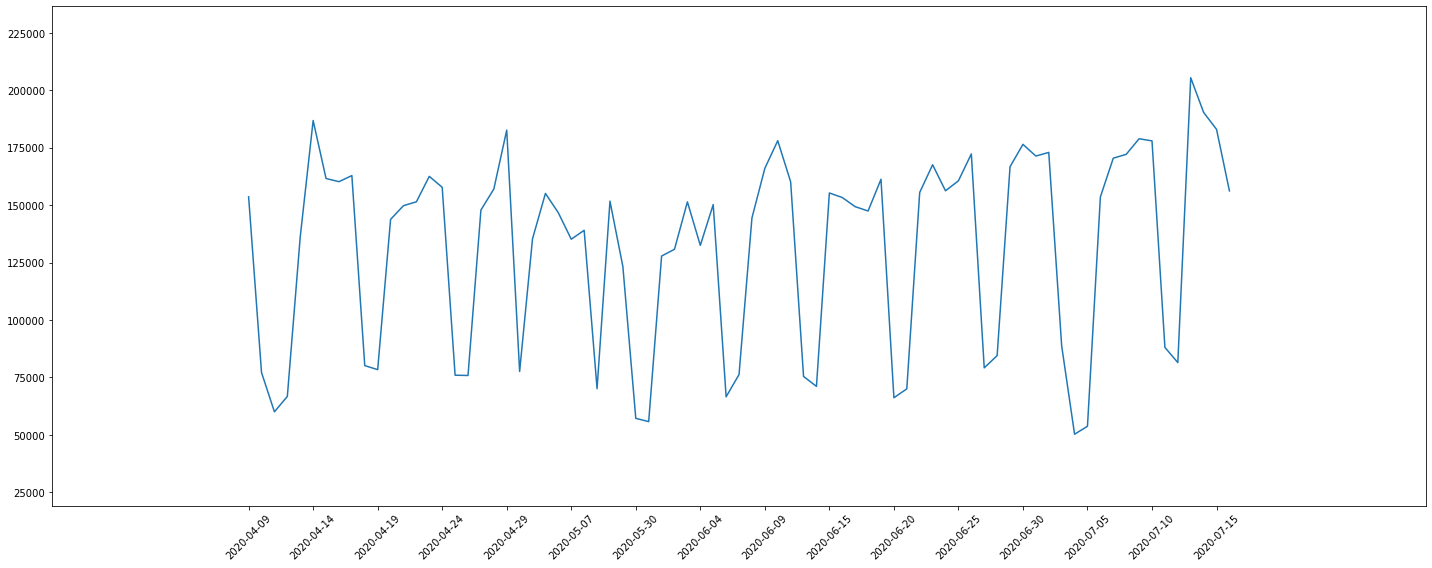

In [120]:
def plot_dense_line_chart(x, y): 
    # Risize the figure (optional)    
    plt.figure(figsize=(20,8))

    # Plot the x and y values on the graph
    plt.plot(x, y)

    # Here you specify the ticks you want to display
    # You can also specify rotation for the tick labels in degrees or with keywords.
    plt.xticks(x[::5],  rotation=45)

    # Add margins (padding) so that markers don't get clipped by the axes
    plt.margins(0.2)

    # Display the graph
    plt.show()

plot_dense_line_chart(tmp['date_prune'], tmp['tweet_size'])

In [67]:
condense_df

,tweets_processed,tweet_size
date_prune,,
2020-04-09,"[targets, long, short, btc, url, url, realesta...",153618
2020-04-10,"[short, sale, volume, short, url, shape, recov...",77124
2020-04-11,"[jeffreyepstein, ghislainemaxwell, markepstein...",60031
2020-04-12,"[rt, biggest, mistakes, apple, pc, maker, amaz...",66723
2020-04-13,"[short, sale, volume, short, url, profit, earn...",136188
...,...,...
2020-07-12,"[want, learn, yaonology, service, visit, new, ...",81464
2020-07-13,"[breaking, finances, valuation, url, url, url,...",205455
2020-07-14,"[apple, air, pods, wired, charging, url, apple...",190338


In [66]:
condense_df.describe()

,tweet_size
count,77.000000
mean,131451.675325
std,43051.894381
min,50268.000000
25%,80141.000000
50%,149763.000000
75%,161590.000000
max,205455.000000


In [68]:
condense_df.to_pickle("Related_dataset/corpus.pkl")

## III. only take into account tweets that contain explicit statements of their author’s mood states 
i.e. those that match the
expressions “i feel”,“i am feeling”,“i’m feeling”,“i dont feel”, “I’m”,
“Im”, “I am”, and “makes me”.

資料只有Bollen 1/10 先不寫

##  取得yfinance → DJIA 財金資料 to dataframe2

沒有我們要的區間：） <br>
改用以下的方法

In [80]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [81]:
from pandas_datareader import data, wb
DJIA = data.DataReader(name='^DJI', data_source='yahoo',start=start_date, end=end_date)
DJIA 

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-08,23513.400391,22682.990234,22893.470703,23433.570312,472740000,23433.570312
2020-04-09,24008.990234,23504.089844,23690.660156,23719.369141,566400000,23719.369141
2020-04-13,23698.929688,23095.349609,23698.929688,23390.769531,394320000,23390.769531
2020-04-14,24040.580078,23683.439453,23690.570312,23949.759766,485910000,23949.759766
2020-04-15,23649.720703,23233.320312,23600.720703,23504.349609,437630000,23504.349609
...,...,...,...,...,...,...
2020-07-10,26101.320312,25637.500000,25690.349609,26075.300781,338170000,26075.300781
2020-07-13,26639.089844,26044.230469,26225.070312,26085.800781,425320000,26085.800781
2020-07-14,26690.519531,25994.980469,26044.169922,26642.589844,401640000,26642.589844


In [82]:
DJIA.to_csv("Related_dataset/DJIA_price.csv")

# Emoji Analysis